In [1]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchaudio
import librosa
from transformers import ASTForAudioClassification, ASTFeatureExtractor
from sklearn.metrics.pairwise import cosine_similarity

class MusicGenreDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, max_duration=15):  # max_duration in seconds
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.max_duration = max_duration
        self.genres = os.listdir(root_dir)
        self.file_paths = []
        self.labels = []

        for genre in self.genres:
            genre_dir = os.path.join(root_dir, genre)
            for file_name in os.listdir(genre_dir):
                if file_name.endswith('.mp3'):
                    self.file_paths.append(os.path.join(genre_dir, file_name))
                    self.labels.append(self.genres.index(genre))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        # Convert stereo to mono if necessary
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = waveform.squeeze().numpy()
        waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

        # Calculate the start and end indices for the middle 15 seconds
        total_samples = len(waveform)
        start_sample = max(0, (total_samples - self.max_duration * 16000) // 2)
        end_sample = min(total_samples, start_sample + self.max_duration * 16000)
        waveform = waveform[start_sample:end_sample]

        # Calculate max_length based on max_duration
        max_length = self.max_duration * 16000
        inputs = self.feature_extractor(waveform, sampling_rate=16000, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
        return inputs, file_path, label

# Initialize the feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Create the dataset
dataset = MusicGenreDataset(root_dir="/kaggle/input/edmmusicclassification", feature_extractor=feature_extractor, max_duration=15)


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [2]:
def load_fine_tuned_model(model_path, num_labels, device):
    """
    Load a fine-tuned ASTForAudioClassification model from the specified path.

    Args:
        model_path (str): The path to the directory where the fine-tuned model is saved.
        num_labels (int): The number of labels (genres) the model was fine-tuned on.
        device (torch.device): The device to load the model onto (e.g., 'cuda' or 'cpu').

    Returns:
        model (ASTForAudioClassification): The loaded fine-tuned model.
    """
    # Load the model architecture
    model = ASTForAudioClassification.from_pretrained(model_path, num_labels=num_labels)

    # Move the model to the specified device
    model.to(device)

    return model


# Load the fine-tuned model
model_path = "/kaggle/input/modelast/tensorflow2/default/1"
num_labels = len(dataset.genres)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_fine_tuned_model(model_path, num_labels, device)
model.eval()

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [3]:
def get_song_embedding(file_path, model, feature_extractor, device, max_duration=15):
    waveform, sample_rate = torchaudio.load(file_path)

    # Convert stereo to mono if necessary
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    waveform = waveform.squeeze().numpy()
    waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

    # Calculate the start and end indices for the middle 15 seconds
    total_samples = len(waveform)
    start_sample = max(0, (total_samples - max_duration * 16000) // 2)
    end_sample = min(total_samples, start_sample + max_duration * 16000)
    waveform = waveform[start_sample:end_sample]

    # Calculate max_length based on max_duration
    max_length = max_duration * 16000
    inputs = feature_extractor(waveform, sampling_rate=16000, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
    inputs = inputs['input_values'].squeeze(1).to(device)  # Extract and squeeze the spectrogram

    with torch.no_grad():
        outputs = model(input_values=inputs, output_hidden_states=True)
        embedding = outputs.hidden_states[-1].mean(dim=1)  # Use the mean of the last hidden state as the embedding

    return embedding.cpu().numpy()

def recommend_similar_songs(dataset, model, feature_extractor, device, k=5):
    # Pick 3 random songs
    random_indices = random.sample(range(len(dataset)), 3)
    random_songs = [dataset.file_paths[i] for i in random_indices]

    # Extract embeddings for all songs in the dataset
    embeddings = []
    file_paths = []
    genres = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=1, shuffle=False):
            inputs, file_path, label = batch
            inputs = inputs['input_values'].squeeze(1).to(device)  # Extract and squeeze the spectrogram
            outputs = model(input_values=inputs, output_hidden_states=True)
            embedding = outputs.hidden_states[-1].mean(dim=1)  # Use the mean of the last hidden state as the embedding
            embeddings.append(embedding.cpu().numpy())
            file_paths.append(file_path[0])
            genres.append(label.item())

    embeddings = np.concatenate(embeddings, axis=0)

    # Compute similarity and recommend songs
    recommendations = []
    for song_path in random_songs:
        input_embedding = get_song_embedding(song_path, model, feature_extractor, device)
        similarities = cosine_similarity(input_embedding, embeddings).flatten()
        top_k_indices = similarities.argsort()[-k:][::-1]
        recommended_songs = [(os.path.basename(file_paths[i]), similarities[i], dataset.genres[genres[i]]) for i in top_k_indices]
        recommendations.append((os.path.basename(song_path), recommended_songs))

    return recommendations


# Recommend similar songs
recommendations = recommend_similar_songs(dataset, model, feature_extractor, device, k=5)
for song_name, recommended_songs in recommendations:
    print(f"Input Song: {song_name}")
    for rec_song, similarity, genre in recommended_songs:
        print(f"Recommended Song: {rec_song}, Similarity: {similarity:.4f}, Genre: {genre}")

Input Song: Namtso (Extended Mix).mp3
Recommended Song: Namtso (Extended Mix).mp3, Similarity: 1.0000, Genre: Downtempo
Recommended Song: Volen Sentir  Makebo  Alchemist (Original Mix).mp3, Similarity: 0.9541, Genre: Downtempo
Recommended Song: The Temper Trap - Sweet Disposition (John Summit  Silver Panda Remix).mp3, Similarity: 0.9473, Genre: MelodicHouse
Recommended Song: Breathe (Extended Mix).mp3, Similarity: 0.9463, Genre: ProgressiveHouse
Recommended Song: PROFF  Volen Sentir  - The Rumble - Original Mix.mp3, Similarity: 0.9463, Genre: Downtempo
Input Song: Marie Vaunt  ASYS - Give Me Acid (Original Mix).mp3
Recommended Song: Marie Vaunt  ASYS - Give Me Acid (Original Mix).mp3, Similarity: 1.0000, Genre: Techno
Recommended Song: Pleasurekraft - Wirehead (Original Mix) Kraftek.mp3, Similarity: 0.9533, Genre: Techno
Recommended Song: Maddix - Im From Holland (Extended Mix).mp3, Similarity: 0.9482, Genre: Techno
Recommended Song: Hype Boy (Extended Mix).mp3, Similarity: 0.9444, Gen

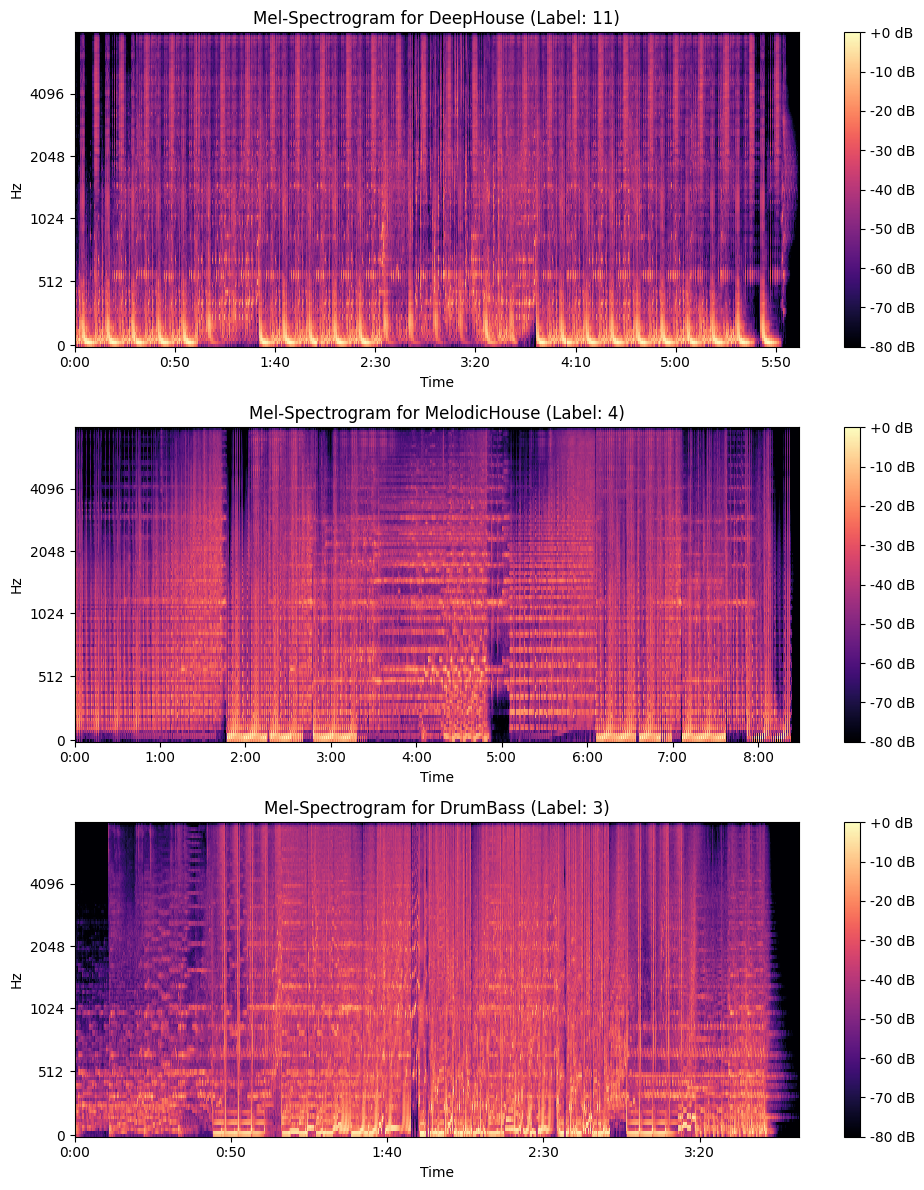

In [5]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def visualize_true_spectrograms(dataset, num_samples=3):
    """
    Visualizes true mel-spectrograms and their labels for random samples from the dataset.

    Args:
        dataset (MusicGenreDataset): The dataset instance.
        num_samples (int): Number of samples to visualize. Default is 3.
    """
    random_indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples))

    if num_samples == 1:
        axes = [axes]

    for i, idx in enumerate(random_indices):
        file_path = dataset.file_paths[idx]
        label = dataset.labels[idx]
        genre_name = dataset.genres[label]

        # Load waveform
        waveform, sr = librosa.load(file_path, sr=16000)
        
        # Compute mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform, sr=16000, n_mels=128, fmax=8000
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plot
        img = librosa.display.specshow(
            mel_spectrogram_db, sr=16000, x_axis="time", y_axis="mel", ax=axes[i]
        )
        axes[i].set_title(f"Mel-Spectrogram for {genre_name} (Label: {label})")
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

# Call the function to visualize 3 random samples
visualize_true_spectrograms(dataset)